# Downloading and compressing images

In this notebook, we download 1000 TIFF images from the RAISE dataset. We then compress the images into single compressed and double compressed versions with various QFs. We also save "uncompressed" images as a JPEG file, using QF=100 and subsampling=0 to give an image that is visually indistinguishable to the original image. This allows us to use the image as input for an existing detection network, which assumes images are stored in JPEG format.

## Acknowledgements

We use the RAISE dataset: http://loki.disi.unitn.it/RAISE/

## Preparation

Imports

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL
from PIL import Image
from multiprocessing.dummy import Pool
import threading
import requests
from itertools import repeat
from google.colab import drive

# Mount Google Drive and set default path
drive.mount('/content/drive')

# IMPORTANT: Change this to your own path, ending with "dataset/"
PATH = '/content/drive/MyDrive/dataset/'

## Download images

Read CSV of URLs to the TIFF images. We use the limited 1000 image dataset

In [ ]:
image_urls = pd.read_csv(PATH + "RAISE_1k.csv")["TIFF"]
print(image_urls)

0      http://193.205.194.113/RAISE/TIFF/r000da54ft.TIF
1      http://193.205.194.113/RAISE/TIFF/r001d260dt.TIF
2      http://193.205.194.113/RAISE/TIFF/r002fc3e2t.TIF
3      http://193.205.194.113/RAISE/TIFF/r00444b95t.TIF
4      http://193.205.194.113/RAISE/TIFF/r005f3e70t.TIF
                             ...                       
995    http://193.205.194.113/RAISE/TIFF/r1f48d12dt.TIF
996    http://193.205.194.113/RAISE/TIFF/r1f4a44a7t.TIF
997    http://193.205.194.113/RAISE/TIFF/r1f4f8a51t.TIF
998    http://193.205.194.113/RAISE/TIFF/r1f5ad4e0t.TIF
999    http://193.205.194.113/RAISE/TIFF/r1f5c8451t.TIF
Name: TIFF, Length: 1000, dtype: object


Download TIFF images

In [ ]:
def download(i):
    '''Downloads the i^th TIFF image and saves it as image_i.tiff'''

    img_data = requests.get(image_urls[i]).content
    with open(PATH + f'raise/tiff/image_{i}.tiff', 'wb') as handler:
        handler.write(img_data)
    return i

In [ ]:
# Download the 1000 images. Use a threadpool for efficiency
with Pool(threading.active_count()) as p:
    p.map(download, range(1000))

Verify image downloaded and saved

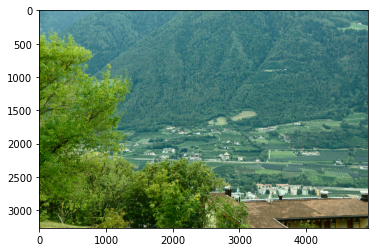

In [ ]:
# Display an image
img = Image.open(PATH + f'raise/tiff/image_380.tiff')
img_array = np.array(img)
plt.imshow(img_array)

## Compress images

Compression functions

In [3]:
def single_compress(x, QF=50):
    '''Compress the x^th image with the given QF'''

    try:
        img = Image.open(PATH + f'raise/tiff/image_{x}.tiff')
        img.save(
            PATH + f'raise/sjpeg{QF}/image_{x}.jpg', optimize=True, quality=QF)
        return x
    except:
        print(f"Could not compress: {x}")


def double_compress(x, SQF=50, DQF=90):
    '''Compress the x^th image with the given SQF and then again with the 
    given DQF'''

    try:
        img = Image.open(PATH + f'raise/sjpeg{SQF}/image_{x}.jpg')
        img.save(
            PATH + f'raise/djpeg{SQF}{DQF}/image_{x}.jpg', optimize=True, quality=DQF)
        return x
    except:
        print(f"Could not compress: {x}")


def no_compress(x):
    '''Save the x^th image as a JPEG file. QF=100 and subsampling=0 produces an
    image that is visually indistinguishable to the original image'''

    try:
        img = Image.open(PATH + f'raise/tiff/image_{x}.tiff')
        img.save(
            PATH + f'raise/njpeg/image_{x}.jpg', optimize=True, quality=100, subsampling=0)
        return x
    except:
        print(f"Could not compress: {x}")

Single compress images with various QFs. Use a threadpool for efficiency.

In [ ]:
# Single compress
for QF in [10, 30, 50, 70, 90]:
    with Pool(2*threading.active_count()) as p:
        p.starmap(single_compress, zip(range(1000), repeat(QF)))
    print(f"QF={QF} complete")

Double compress images with various QFs. Use a threadpool for efficiency.

In [4]:
# Double compress
for QF in [10, 30, 50, 70, 90]:
    with Pool(2*threading.active_count()) as p:
        p.starmap(double_compress, zip(range(1000), repeat(50), repeat(QF)))
    print(f"QF={QF} complete")

Save the uncompressed images as a JPEG. Use a threadpool for efficiency.

In [ ]:
# Uncompressed as JPEG
with Pool(threading.active_count()) as p:
    p.map(no_compress, range(1000))